In [1]:
import numpy as np
import pandas as pd
import fdringdown as rd
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

from plot_utils import rcparams, c_t0_prior, conversion, t_ref, gaussian
plt.rcParams.update(rcparams)

import json
import h5py
import qnm

In [2]:
t0_choices = np.arange(-10, 26, 5)

# Capano
run_dict_capano = {
    '1W220': [8, 9, 10, 11, 12, 13, 14, 15],
    '1W220221': [13, 14, 15, 16, 17, 18, 19, 20],
    '1W220330': [7, 8, 9, 10, 11, 12, 13, 14],
    }

# Normal
run_dict_normal = {
    '1W220': [16, 17, 18, 19, 20, 21, 22, 23],
    '1W220221': [21, 22, 23, 24, 25, 26, 27, 28],
    '1W220330': [31, 16, 17, 18, 19, 20, 21, 22],
    }

# Normal fixed inclination
run_dict_normal_fixed_inc = {
    '1W220': [24, 25, 26, 27, 28, 29, 30, 31],
    '1W220221': [29, 30, 31, 32, 33, 34, 35, 36],
    '1W220330': [23, 24, 25, 26, 27, 28, 29, 30],
    }

# Filenames for Capano overtone amplitude posteriors
capano_post_overtone = {
    (-7/1000)/conversion: '220_221/KERR-220_221-M07MS.hdf',
    (-5/1000)/conversion: '220_221/KERR-220_221-M05MS.hdf',
    (6/1000)/conversion: '220_221/KERR-220_221-06MS.hdf',
    (7/1000)/conversion: '220_221/KERR-220_221-07MS.hdf',
    }

capano_post_harmonic = {
    (6/1000)/conversion: '220_330/KERR-220_330-06MS.hdf',
    (7/1000)/conversion: '220_330/KERR-220_330-07MS.hdf',
    }

# Load Capano evidences
capano_Z220 = np.loadtxt('BH-Spectroscopy-GW190521/posteriors/evidence/220_evidence.txt')
capano_Z221 = np.loadtxt('BH-Spectroscopy-GW190521/posteriors/evidence/220_221_evidence.txt')
capano_Z330 = np.loadtxt('BH-Spectroscopy-GW190521/posteriors/evidence/220_330_evidence.txt')

### Whitened GW190521 data in Livingston

In [3]:
# Create the event class
event = rd.GWevent('GW190521')

Loading file V-V1_GWOSC_4KHZ_R1-1242440920-4096.hdf5
Loading file H-H1_GWOSC_4KHZ_R1-1242440920-4096.hdf5
Loading file L-L1_GWOSC_4KHZ_R1-1242440920-4096.hdf5


In [4]:
# Get the event GPS time
gps = event.parameters['GPS']

# Load the LIGO PSDs
asd_dict = {}
PSD_path = '../../runs/GW190521/GWTC_PSD'
for IFO_name in event.IFO_names:
    freqs, psd = np.loadtxt(f'{PSD_path}/{IFO_name}.dat').T
    # Square root to get the ASD, interpolate, and store to dictionary
    asd_dict[IFO_name] = interp1d(freqs, np.sqrt(psd), bounds_error=False)

# Get the analysis data. We use 4 seconds of data centered on the GPS time.
analysis_time, analysis_data = event.get_data_segment(
    event.time,
    event.data,
    start_time=gps-2, 
    segment_length=4*event.fs, 
    window=('tukey', 0.2)
    )

# Whiten the Livingston data.
whitened_data = rd.utils.whiten(
    analysis_data['L1'],
    asd_dict['L1'],
    event.dt,
    (16,256)
    )

### Custom violin for amplitude posteriors

In [5]:
def custom_violin(posterior, kde, vals, color, x_loc, ax):
    
    # Error bar
    # ---------
    
    l_5, l_50, l_95 = np.quantile(
        posterior, 
        [0.05,0.5,0.95]
        )
    
    mean = np.average(posterior)
    
    ax.plot(x_loc, l_50, 'o', c=color)
    ax.errorbar(
        x_loc, 
        l_50, 
        yerr=np.array([[l_50-l_5],[l_95-l_50]]),
        ecolor=color,
        capsize=5,
        )
    
    # Violin plot
    # -----------
    
    vpstats = [{
        'coords': vals,
        'vals': kde(vals),
        'mean': mean,
        'median': l_50,
        'min': np.min(vals),
        'max': np.max(vals)
        }]
    
    vplot = ax.violin(
        vpstats, 
        [x_loc], 
        vert=True, 
        widths=1.5,
        showmeans=False, 
        showextrema=False, 
        showmedians=False
        )
    
    vplot['bodies'][0].set_facecolor(color)

### Choose analysis

In [6]:
# --------------------

# run_dict = run_dict_normal
# capano_post = capano_post_harmonic

# run_type = '1W220330'
# ax1_ylim = 1
# ax1_label = r'$A_{330}\ [\times 10^{21}]$'

# # Compute Capano Bayes factors
# capano_Z220_cut = []
# for t0 in capano_Z330[:,0]:
#     capano_Z220_cut.append(capano_Z220[np.where(capano_Z220[:,0] == t0)[0][0]])
# capano_Z220 = np.array(capano_Z220_cut)

# capano_times = (capano_Z220[:,0]/1000)/conversion

# capano_Z220 = capano_Z220[:,1]
# capano_Z330 = capano_Z330[:,1]

# capano_log10_B = np.log10(np.e)*(capano_Z330 - capano_Z220)

# --------------------

run_dict = run_dict_normal
capano_post = capano_post_overtone

run_type = '1W220221'
ax1_ylim = 10
ax1_label = r'$A_{221}\ [\times 10^{21}]$'

# Compute Capano Bayes factors
capano_Z220_cut = []
for t0 in capano_Z221[:,0]:
    capano_Z220_cut.append(capano_Z220[np.where(capano_Z220[:,0] == t0)[0][0]])
capano_Z220 = np.array(capano_Z220_cut)

capano_times = (capano_Z220[:,0]/1000)/conversion

capano_Z220 = capano_Z220[:,1]
capano_Z221 = capano_Z221[:,1]

capano_log10_B = np.log10(np.e)*(capano_Z221 - capano_Z220)

# --------------------

# run_dict = run_dict_normal_fixed_inc
# capano_post = capano_post_overtone

# run_type = '1W220221'
# ax1_ylim = 5
# ax1_label = r'$A_{221}\ [\times 10^{21}]$'

In [7]:
# Load evidences
logz_dict = {}
logz_err_dict = {}

for rtype in ['1W220', run_type]:
    runs = run_dict[rtype]
    run_dir = f'../../runs/GW190521/{rtype}'
    logz_dict[rtype] = []
    logz_err_dict[rtype] = []
    for run in runs:
        with open(f'{run_dir}/{run:02d}/sampler_output.json', 'r') as f:
            sampler_output = json.load(f)
        logz_dict[rtype].append(sampler_output['logz'])
        logz_err_dict[rtype].append(sampler_output['logzerr'])

### Create figure

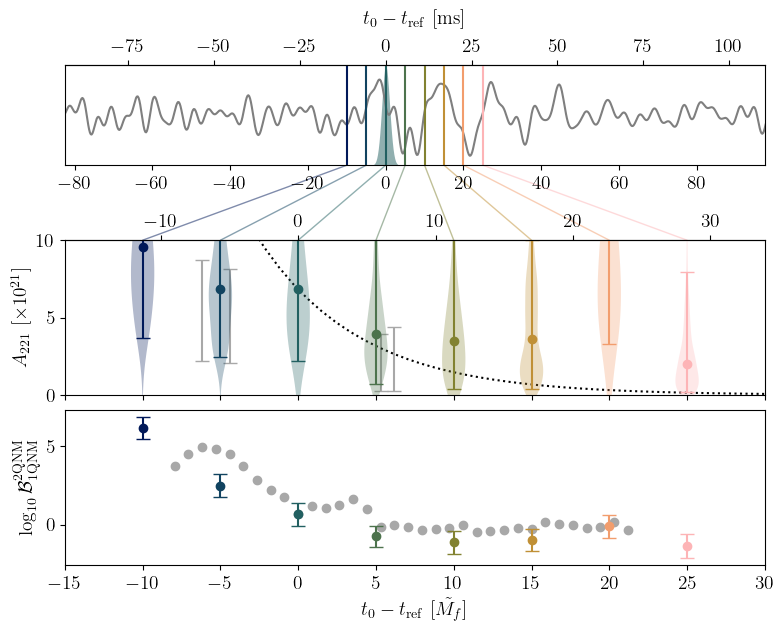

In [13]:
fig_width = 7
fig_height = 5

fig = plt.figure(figsize=(fig_width, fig_height))


# Create axes
# -----------

ax0_pad = 0.15
h_ratio = 2/10

wf_grid = fig.add_gridspec(
    1, 1, 
    top=1, bottom=1-h_ratio, left=0, right=1
    )
ax0 = wf_grid.subplots()

main_grid = fig.add_gridspec(
    2, 1, 
    top=1-h_ratio-ax0_pad, bottom=0, left=0, right=1, 
    hspace=0.1
    )
ax1 = fig.add_subplot(main_grid[0])
ax2 = fig.add_subplot(main_grid[1])


# Add whitened waveform
# ---------------------

ax0.plot((analysis_time-t_ref)/conversion, whitened_data, c='C7')

for i, t0 in enumerate(t0_choices):
    ax0.axvline(t0, c=c_t0_prior[i])

x = np.linspace(-40, 40, 400)
ax0.fill_between(x, gaussian(x)*10-2, -2, color=c_t0_prior[2], alpha=0.5, lw=0)


# Connecting lines
# ----------------

for i, t0 in enumerate(t0_choices):
    
    fig.add_artist(
        ConnectionPatch(
            xyA=(t0,-2), 
            coordsA=ax0.transData, 
            xyB=(t0,ax1_ylim), 
            coordsB=ax1.transData,
            color=c_t0_prior[i],
            alpha=0.5,
            zorder=-10
            )
        )
    
    
# Amplitude posteriors
# --------------------

# Values to evaluate the amplitude KDEs on
A_vals = np.linspace(0, 50, 1000)

for i, run_number in enumerate(run_dict[run_type]):

    c = c_t0_prior[i]
    t0 = t0_choices[i]

    posterior = pd.read_csv(
        f'../../runs/GW190521/{run_type}/{run_number:02d}/posterior_samples.dat'
        )
    amp_posterior = np.array(posterior.A_rd_1)*1e21
    amp_kde = gaussian_kde(amp_posterior, bw_method=0.2)
    
    custom_violin(
        amp_posterior, 
        amp_kde, 
        A_vals, 
        c, 
        t0, 
        ax1
    )
    
# Add available Capano comparisons as error bars
for t0, file_name in capano_post.items():
    
    with h5py.File(f'BH-Spectroscopy-GW190521/posteriors/kerr/{file_name}', 'r') as f:
        amp0 = np.array(f['samples']['amp220'])
        amp1_over_amp0 = np.array(f['samples'][f'amp{file_name[4:7]}'])
        
    amp1 = amp0*amp1_over_amp0*1e21
    
    l_5, l_50, l_95 = np.quantile(
        amp1, 
        [0.05,0.5,0.95]
        )
    
    ax1.errorbar(
        t0, 
        l_50, 
        yerr=np.array([[l_50-l_5],[l_95-l_50]]),
        ecolor='#a8a8a8',
        capsize=5,
        zorder=-10
        )

    
# Expected amplitude decay
# ------------------------

IMR_chif_median = 0.85
t_vals = np.linspace(-15, 30)

qnm_func = qnm.modes_cache(-2, 2, 2, 1)
omega, A, C = qnm_func(IMR_chif_median)
tau = 1.4*(-1/np.imag(omega))

posterior = pd.read_csv(
    f'../../runs/GW190521/{run_type}/{run_dict[run_type][2]:02d}/posterior_samples.dat'
)
amp_posterior = np.array(posterior.A_rd_1)*1e21

A0 = np.median(amp_posterior)
Aoft = A0*np.exp(-(t_vals)/tau)

ax1.plot(t_vals, Aoft, c='k', linestyle='dotted', zorder=-5)


# Bayes factors
# -------------

logz_list = np.array(logz_dict[run_type])
logz_err_list = np.array(logz_err_dict[run_type])

log10_bayes = np.log10(np.e)*(logz_list - np.array(logz_dict['1W220']))

loge_bayes_e = np.sqrt(logz_err_list**2 + np.array(logz_err_dict['1W220'])**2)
log10_bayes_err = np.log10(np.e)*loge_bayes_e

for i, t0 in enumerate(t0_choices):

    ax2.plot(t0, log10_bayes[i], 'o', c=c_t0_prior[i])
    ax2.errorbar(
        t0,
        log10_bayes[i],
        yerr=1.645*log10_bayes_err[i],
        ecolor=c_t0_prior[i],
        capsize=5,
    )
    
# Add Capano comparison
ax2.plot(capano_times, capano_log10_B, 'o', c='#a8a8a8', zorder=-10)
 

# Adjustments
# -----------

# Limits
ax0.set_xlim(7.5-90, 7.5+90)
ax0.set_ylim(-2, 2)

ax1.set_xlim(-15, 30)
ax1.set_ylim(0, ax1_ylim)

ax2.set_xlim(-15, 30)

# Ticks
ax0.set_yticks([])

ax1.set_xticklabels([])

# Labels
ax1.set_ylabel(ax1_label)
ax2.set_ylabel('$\log_{10} \mathcal{B}^\mathrm{2QNM}_\mathrm{1QNM}$')
ax2.set_xlabel(r'$t_0 - t_\mathrm{ref}\ [\tilde{M_f}]$')

# Secondary axis
def M_to_ms(x):
    return (x*conversion)*1000
def ms_to_M(x):
    return (x/conversion)/1000

secax = ax0.secondary_xaxis('top', functions=(M_to_ms, ms_to_M))
_ = secax.set_xlabel(r'$t_0 - t_\mathrm{ref}\ [\mathrm{ms}]$', labelpad=10)

ax1.secondary_xaxis('top', functions=(M_to_ms, ms_to_M))

#

fig.savefig('summary_figure.pdf', bbox_inches='tight')